In [1]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import MarkerCluster
from haversine import haversine
import math
from sklearn.cluster import KMeans

def load_gpx_to_dataframe(gpx_file):
    """
    Load a GPX file into a pandas DataFrame with distance calculations
    """
    with open(gpx_file, 'r') as f:
        gpx = gpxpy.parse(f)
    
    # Extract points
    points = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                points.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation if point.elevation else 0,
                    'time': point.time
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(points)
    
    # Calculate cumulative distance
    df['segment_distance'] = 0.0
    for i in range(1, len(df)):
        point1 = (df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
        point2 = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        df.loc[i, 'segment_distance'] = haversine(point1, point2, unit='km')
    
    df['cumulative_distance'] = df['segment_distance'].cumsum()
    
    # Calculate elevation gain/loss
    df['elevation_change'] = 0.0
    for i in range(1, len(df)):
        df.loc[i, 'elevation_change'] = df.iloc[i]['elevation'] - df.iloc[i-1]['elevation']
    
    df['elevation_gain'] = df['elevation_change'].apply(lambda x: max(0, x))
    df['elevation_loss'] = df['elevation_change'].apply(lambda x: abs(min(0, x)))
    df['cumulative_elevation_gain'] = df['elevation_gain'].cumsum()
    
    return df

def calculate_optimal_rv_stops(route_df, target_distance=125):
    """
    Calculate optimal RV stop locations based on target daily distance
    """
    total_distance = route_df['cumulative_distance'].iloc[-1]
    num_days = math.ceil(total_distance / target_distance)
    
    # Simple approach: divide route into equal segments
    optimal_stops = []
    for day in range(1, num_days):
        target_distance_km = day * target_distance
        # Find the closest point to the target distance
        closest_idx = (route_df['cumulative_distance'] - target_distance_km).abs().idxmin()
        optimal_stops.append({
            'day': day,
            'distance_km': route_df.loc[closest_idx, 'cumulative_distance'],
            'latitude': route_df.loc[closest_idx, 'latitude'],
            'longitude': route_df.loc[closest_idx, 'longitude'],
            'elevation': route_df.loc[closest_idx, 'elevation'],
            'elevation_gain_so_far': route_df.loc[closest_idx, 'cumulative_elevation_gain']
        })
    
    return optimal_stops

def find_nearby_facilities(lat, lon, radius_km=5):
    """
    Placeholder for finding nearby facilities - in a real application, 
    this would connect to an API like Google Places or OpenStreetMap
    """
    # This is a simplified mock function - in reality, you'd use an API
    # to find actual facilities near each point
    return {
        'has_gas_station': np.random.choice([True, False], p=[0.7, 0.3]),
        'has_grocery': np.random.choice([True, False], p=[0.5, 0.5]),
        'has_lodging': np.random.choice([True, False], p=[0.4, 0.6]),
        'has_water': np.random.choice([True, False], p=[0.8, 0.2])
    }

def analyze_route_segments(route_df, stops):
    """
    Analyze each day's segment for difficulty and key statistics
    """
    segments = []
    
    # Add starting point
    start_point = {
        'day': 0,
        'distance_km': 0,
        'latitude': route_df.iloc[0]['latitude'],
        'longitude': route_df.iloc[0]['longitude'],
        'elevation': route_df.iloc[0]['elevation'],
        'elevation_gain_so_far': 0
    }
    
    all_stops = [start_point] + stops + [{
        'day': len(stops) + 1,
        'distance_km': route_df.iloc[-1]['cumulative_distance'],
        'latitude': route_df.iloc[-1]['latitude'],
        'longitude': route_df.iloc[-1]['longitude'],
        'elevation': route_df.iloc[-1]['elevation'],
        'elevation_gain_so_far': route_df.iloc[-1]['cumulative_elevation_gain']
    }]
    
    for i in range(len(all_stops)-1):
        start = all_stops[i]
        end = all_stops[i+1]
        
        # Filter route for this segment
        start_idx = (route_df['cumulative_distance'] - start['distance_km']).abs().idxmin()
        end_idx = (route_df['cumulative_distance'] - end['distance_km']).abs().idxmin()
        
        segment_df = route_df.iloc[start_idx:end_idx+1].copy()
        
        # Calculate segment statistics
        segment_distance = end['distance_km'] - start['distance_km']
        segment_elevation_gain = end['elevation_gain_so_far'] - start['elevation_gain_so_far']
        
        # Estimate difficulty
        difficulty = 1.0
        difficulty += segment_elevation_gain / 500  # Add 1 difficulty point per 500m of elevation gain
        
        # More metrics could be added here: terrain roughness, expected temperatures, etc.
        
        segments.append({
            'day': i+1,
            'start_point': (start['latitude'], start['longitude']),
            'end_point': (end['latitude'], end['longitude']),
            'distance_km': segment_distance,
            'elevation_gain_m': segment_elevation_gain,
            'difficulty_score': round(difficulty, 2),
            'estimated_hours': segment_distance / 8  # Assuming 8 km/h pace
        })
    
    return segments

def create_route_map(route_df, stops, route_name="Route"):
    """
    Create an interactive map showing the route and optimal RV stops
    """
    # Create a map centered on the route
    center_lat = route_df['latitude'].mean()
    center_lon = route_df['longitude'].mean()
    route_map = folium.Map(location=[center_lat, center_lon], zoom_start=8)
    
    # Add the route line
    points = [(row['latitude'], row['longitude']) for _, row in route_df.iterrows()]
    folium.PolyLine(points, color='blue', weight=3, opacity=0.7).add_to(route_map)
    
    # Add markers for start and end
    folium.Marker(
        [route_df.iloc[0]['latitude'], route_df.iloc[0]['longitude']],
        popup='Start: Santa Monica Pier',
        icon=folium.Icon(color='green', icon='play', prefix='fa')
    ).add_to(route_map)
    
    folium.Marker(
        [route_df.iloc[-1]['latitude'], route_df.iloc[-1]['longitude']],
        popup='End: Las Vegas',
        icon=folium.Icon(color='red', icon='stop', prefix='fa')
    ).add_to(route_map)
    
    # Add markers for RV stops
    for i, stop in enumerate(stops):
        # Simulate checking for nearby facilities
        facilities = find_nearby_facilities(stop['latitude'], stop['longitude'])
        
        # Create popup content
        popup_html = f"""
        <b>Day {stop['day']} RV Stop</b><br>
        Distance: {stop['distance_km']:.2f} km<br>
        Elevation: {stop['elevation']:.1f} m<br>
        Facilities nearby:<br>
        - Gas station: {'Yes' if facilities['has_gas_station'] else 'No'}<br>
        - Grocery: {'Yes' if facilities['has_grocery'] else 'No'}<br>
        - Lodging: {'Yes' if facilities['has_lodging'] else 'No'}<br>
        - Water: {'Yes' if facilities['has_water'] else 'No'}<br>
        """
        
        folium.Marker(
            [stop['latitude'], stop['longitude']],
            popup=folium.Popup(popup_html, max_width=300),
            icon=folium.Icon(color='orange', icon='home', prefix='fa')
        ).add_to(route_map)
        
    # Add elevation profile as a separate layer
    distances = route_df['cumulative_distance'].tolist()
    elevations = route_df['elevation'].tolist()
    
    # Save the map
    map_filename = f"{route_name.replace(' ', '_')}_map.html"
    route_map.save(map_filename)
    
    return route_map, map_filename

def compare_multiple_routes(gpx_files, target_daily_distance=125):
    """
    Compare multiple GPX routes and find optimal RV stops for each
    """
    route_data = {}
    
    for gpx_file in gpx_files:
        route_name = gpx_file.split('/')[-1].replace('.gpx', '')
        print(f"Processing route: {route_name}")
        
        # Load and process route
        route_df = load_gpx_to_dataframe(gpx_file)
        
        # Calculate optimal RV stops
        rv_stops = calculate_optimal_rv_stops(route_df, target_daily_distance)
        
        # Analyze route segments
        segments = analyze_route_segments(route_df, rv_stops)
        
        # Create map visualization
        route_map, map_filename = create_route_map(route_df, rv_stops, route_name)
        
        # Store all route data
        route_data[route_name] = {
            'df': route_df,
            'total_distance': route_df['cumulative_distance'].iloc[-1],
            'total_elevation_gain': route_df['cumulative_elevation_gain'].iloc[-1],
            'num_days': len(segments),
            'rv_stops': rv_stops,
            'segments': segments,
            'map_filename': map_filename
        }
    
    # Compare routes and create summary visualization
    plot_route_comparison(route_data)
    
    return route_data

def plot_route_comparison(route_data):
    """
    Create visualizations comparing the different routes
    """
    fig = plt.figure(figsize=(15, 12))
    gs = plt.GridSpec(3, 2, height_ratios=[1, 2, 1])
    
    # Plot 1: Basic comparison metrics
    ax1 = fig.add_subplot(gs[0, :])
    
    route_names = list(route_data.keys())
    x = np.arange(len(route_names))
    width = 0.2
    
    distances = [route_data[route]['total_distance'] for route in route_names]
    elevations = [route_data[route]['total_elevation_gain'] for route in route_names]
    days = [route_data[route]['num_days'] for route in route_names]
    
    ax1.bar(x - width, distances, width, label='Distance (km)')
    ax1.bar(x, elevations, width, label='Elevation Gain (m)')
    ax1.bar(x + width, days, width, label='Estimated Days')
    
    ax1.set_title('Route Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(route_names)
    ax1.legend()
    
    # Plot 2: Elevation profiles
    ax2 = fig.add_subplot(gs[1, 0])
    
    for route in route_names:
        df = route_data[route]['df']
        ax2.plot(df['cumulative_distance'], df['elevation'], label=route)
        
        # Mark RV stops on the elevation profile
        for stop in route_data[route]['rv_stops']:
            ax2.scatter(stop['distance_km'], stop['elevation'], color='red', marker='^')
            ax2.text(stop['distance_km'], stop['elevation']+50, f"Day {stop['day']}", fontsize=8)
    
    ax2.set_title('Elevation Profiles')
    ax2.set_xlabel('Distance (km)')
    ax2.set_ylabel('Elevation (m)')
    ax2.grid(True)
    ax2.legend()
    
    # Plot 3: Daily segment comparison
    ax3 = fig.add_subplot(gs[1, 1])
    
    for i, route in enumerate(route_names):
        segments = route_data[route]['segments']
        days = [seg['day'] for seg in segments]
        distances = [seg['distance_km'] for seg in segments]
        difficulties = [seg['difficulty_score'] for seg in segments]
        
        # Size the markers based on difficulty
        sizes = [d * 50 for d in difficulties]
        
        scatter = ax3.scatter(days, distances, s=sizes, label=route, alpha=0.7)
        
        # Add day numbers
        for j, day in enumerate(days):
            ax3.text(day, distances[j]+2, f"D{day}", fontsize=8)
    
    ax3.set_title('Daily Segments Comparison')
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Distance (km)')
    ax3.grid(True)
    ax3.legend()
    
    # Plot 4: Summary table
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for route in route_names:
        data = route_data[route]
        segments = data['segments']
        
        # Calculate statistics
        avg_daily_distance = sum(seg['distance_km'] for seg in segments) / len(segments)
        max_daily_elevation = max(seg['elevation_gain_m'] for seg in segments)
        max_difficulty = max(seg['difficulty_score'] for seg in segments)
        hardest_day = [seg['day'] for seg in segments if seg['difficulty_score'] == max_difficulty][0]
        
        table_data.append([
            route,
            f"{data['total_distance']:.1f} km",
            f"{data['total_elevation_gain']:.0f} m",
            f"{avg_daily_distance:.1f} km",
            f"{max_daily_elevation:.0f} m (Day {hardest_day})",
            f"{data['num_days']} days"
        ])
    
    table = ax4.table(
        cellText=table_data,
        colLabels=['Route', 'Total Distance', 'Total Elevation', 'Avg Daily Distance', 'Max Daily Elevation', 'Est. Days'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    plt.tight_layout()
    plt.savefig('route_comparison_with_rv_stops.png', dpi=300)
    plt.show()

# Example usage:
# gpx_files = ['route1.gpx', 'route2.gpx', 'route3.gpx']
# route_analysis = compare_multiple_routes(gpx_files, target_daily_distance=125)

In [2]:
gpx_files = ['gpx/HS TSP Solo.gpx', 'gpx/TSP_solo.gpx']

Processing route: HS TSP Solo
Processing route: TSP_solo


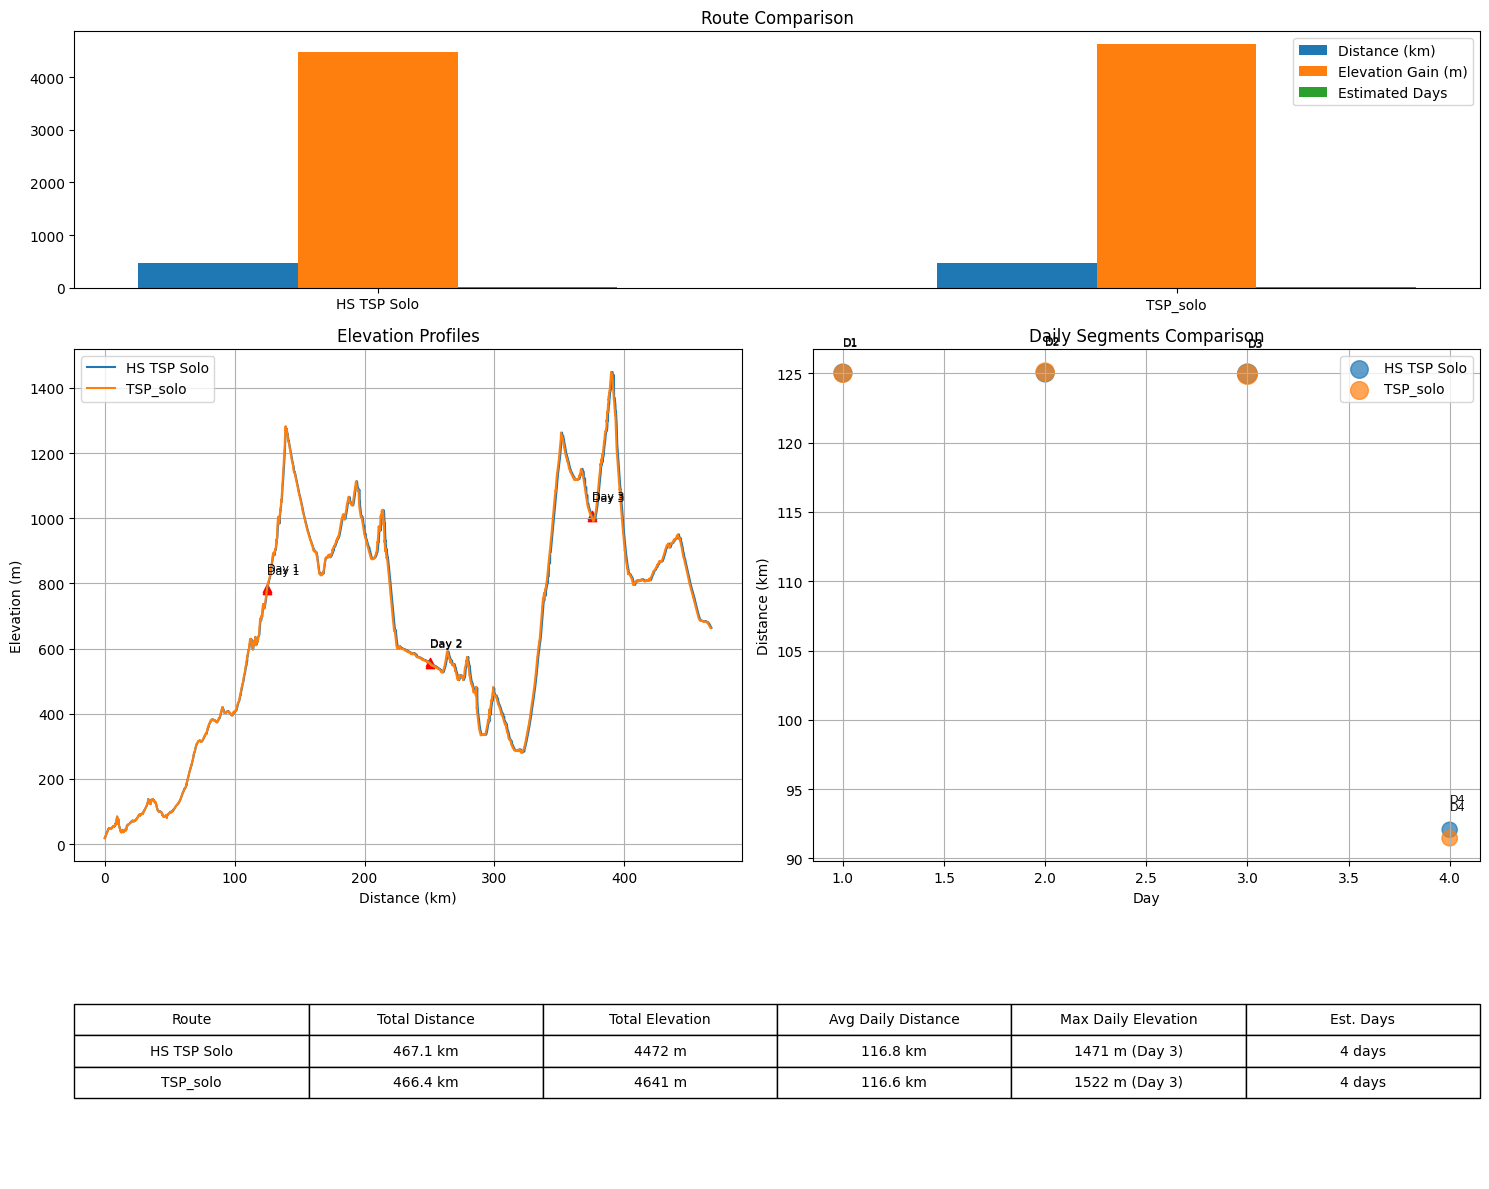

In [3]:
route_analysis = compare_multiple_routes(gpx_files, target_daily_distance=125)